# Identifying High-Value Repeat Buyers for Olist's E-commerce Platform (CAIE tech test 2024)
## Background
Olist is a Brazilian e-commerce marketplace like Lazada, Taobao and Shopee, it is a sales platform that connects small retailers with customers.

## Objective
Main Objective: To identify potential repeat buyers 

## Tasks:
### Exploratory Data Analysis (EDA):
Conduct comprehensive data exploration to identify key factors influencing customer behavior and purchase patterns.

## Deliverables
### Exploratory Data Analysis (EDA):
- Conduct thorough data exploration to understand the distribution and relationships of key features.
- Identify trends, patterns, and correlations that influence repeat buying behavior using visualizations.
- Visualize insights using plots and charts for better interpretation.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Data
Customer_dataset = pd.read_csv('data/olist_customers_dataset.csv')
geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
order_review = pd.read_csv('data/olist_order_reviews_dataset.csv')
order = pd.read_csv('data/olist_orders_dataset.csv')
product = pd.read_csv('data/olist_products_dataset.csv')
seller = pd.read_csv('data/olist_sellers_dataset.csv')
translated_category = pd.read_csv('data/product_category_name_translation.csv')

### Data Analysis

In [3]:
# List of datasets
datasets = {
    'customer_dataset': Customer_dataset,
    'order_items': order_items,
    'order_payments': order_payments,
    'order_review': order_review,
    'order': order,
    'product': product,
    'translated_category': translated_category
}
# Function to describe each dataset
def describe_dataset(name, df):
    print(f"\nDataset: {name}")
    print(df.describe)

# Describe all datasets
for name, df in datasets.items():
    describe_dataset(name, df)


Dataset: customer_dataset
<bound method NDFrame.describe of                             customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       custome

In [4]:
# Initialize lists to store summary information
titles = []
total_rows = []
total_columns = []
total_duplicates = []
total_nulls = []
null_columns_list = []

# Iterate over datasets and gather summary information
for name, df in datasets.items():
    titles.append(name)
    total_rows.append(df.shape[0])
    total_columns.append(df.shape[1])
    total_duplicates.append(len(df[df.duplicated()]))
    total_nulls.append(df.isnull().sum().sum())
    null_columns = df.columns[df.isnull().any()].tolist()
    null_columns_list.append(", ".join(null_columns))

# Create the summary DataFrame
data_summary = pd.DataFrame(
    {
        "Dataset": titles,
        "Total Rows": total_rows,
        "Total Columns": total_columns,
        "Total Duplicates": total_duplicates,
        "Total Nulls": total_nulls,
        "Columns with Nulls": null_columns_list,
    }
)

# Display the summary DataFrame
data_summary


,Dataset,Total Rows,Total Columns,Total Duplicates,Total Nulls,Columns with Nulls
0,customer_dataset,99441,5,0,0,
1,order_items,112650,7,0,0,
2,order_payments,103886,5,0,0,
3,order_review,99224,7,0,145903,"review_comment_title, review_comment_message"
4,order,99441,8,0,4908,"order_approved_at, order_delivered_carrier_dat..."
5,product,32951,9,0,2448,"product_category_name, product_name_lenght, pr..."
6,translated_category,71,2,0,0,


We can see that only geolocation is the only dataset that has many dupes. The other 3 datasets that have null values are order, product and order_review

### Handling of Nulls and dupes

In [5]:
def handle_null_values(datasets):
    # Fill null values in 'review_comment_title' and 'review_comment_message' with "no reviews" in reviews_df
    datasets["order_review"]["review_comment_title"].fillna(
        "No comment title", inplace=True
    )
    datasets["order_review"]["review_comment_message"].fillna(
        "No comment message", inplace=True
    )
    # Drop null values in orders_df and products_df
    datasets["order"].dropna(inplace=True)
    datasets["product"].dropna(inplace=True)

    return datasets


datasets = handle_null_values(datasets)


In [6]:
# Drop duplicates for all datasets in the list
for key, df in datasets.items():
    datasets[key] = df.drop_duplicates()

### Merging of datasets

In [7]:
# Starting with "items" dataset

# Merging "items" with "products" and "orderitems"
main_items = order_items.merge(product, on="product_id")

# To merge items with orders, we need to group and aggregate the data on order_id.
# Group and aggregate values by order_id
main_items = main_items.groupby("order_id").agg(
    {
        "order_item_id": "max",
        "price": "sum",
        "freight_value": "sum",
        "product_category_name": "first",
        "product_photos_qty": "mean",
        "product_weight_g": "mean",
        "product_length_cm": "mean",
        "product_height_cm": "mean",
        "product_width_cm": "mean",
    }
)

display(main_items.head(3))
print(main_items.shape)


,order_item_id,price,freight_value,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
order_id,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,1,58.9,13.29,cool_stuff,4.0,650.0,28.0,9.0,14.0
00018f77f2f0320c557190d7a144bdd3,1,239.9,19.93,pet_shop,2.0,30000.0,50.0,30.0,40.0
000229ec398224ef6ca0657da4fc703e,1,199.0,17.87,moveis_decoracao,2.0,3050.0,33.0,13.0,33.0


(97276, 9)


In [8]:
# When there are multiple payment types, we will combine them into one string.
order_payments = order_payments.groupby("order_id").agg({
    "payment_sequential": "max",
    "payment_type": lambda x: ', '.join(x.unique()),
    "payment_installments": "sum",
    "payment_value": "sum"
}).reset_index()

display(order_payments.head(3))
print(order_payments.shape)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,credit_card,2,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,credit_card,3,259.83
2,000229ec398224ef6ca0657da4fc703e,1,credit_card,5,216.87


(99440, 5)


In [9]:
# Aggregate order_review dataset
order_review = order_review.groupby('order_id').agg({
    'review_id': 'count',  # Count of reviews
    'review_score': 'median',  # Average review score
    'review_creation_date': 'max',  # Last review creation date
    'review_answer_timestamp': 'max'  # Last review answer timestamp
}).reset_index()

In [10]:
# Finally we will merge them all with the main "orders" dataset
olist = order.merge(order_review, on="order_id")
olist = olist.merge(Customer_dataset, on="customer_id")
olist = olist.merge(main_items, on="order_id")
olist = olist.merge(order_payments, on="order_id")
olist = olist.merge(translated_category, on="product_category_name")
display(olist.head(3))
print(olist.shape)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,4.0,...,4.0,500.0,19.0,8.0,13.0,3,"credit_card, voucher",3,38.71,housewares
1,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21 00:00:00,1,1.0,...,6.0,14300.0,38.0,34.0,34.0,1,credit_card,10,356.12,housewares
2,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-04-24 09:34:13,2017-05-10 09:17:55,2017-05-12 00:00:00,1,1.0,...,3.0,705.0,34.0,22.0,28.0,1,boleto,1,267.80,housewares


(94471, 30)


In [11]:
olist.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
review_id                        0
review_score                     0
review_creation_date             0
review_answer_timestamp          0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
price                            0
freight_value                    0
product_category_name            0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value       

In [12]:
olist = olist.drop_duplicates(subset=['order_id'])

Merged all datasets and final check for null values

## Combined Dataset Analysis

The reason for this check is to make sure that the values tally up so that there isnt any further errors

In [13]:
# Convert date columns to datetime
olist["order_purchase_timestamp"] = pd.to_datetime(olist["order_purchase_timestamp"])
olist["order_delivered_customer_date"] = pd.to_datetime(
    olist["order_delivered_customer_date"]
)
olist["order_estimated_delivery_date"] = pd.to_datetime(
    olist["order_estimated_delivery_date"]
)


Converting these columns to date-time to facilitate better analysis

2706 Repeat customers, 91765 toal customers, 2.864371076838395 percent of customers repeated


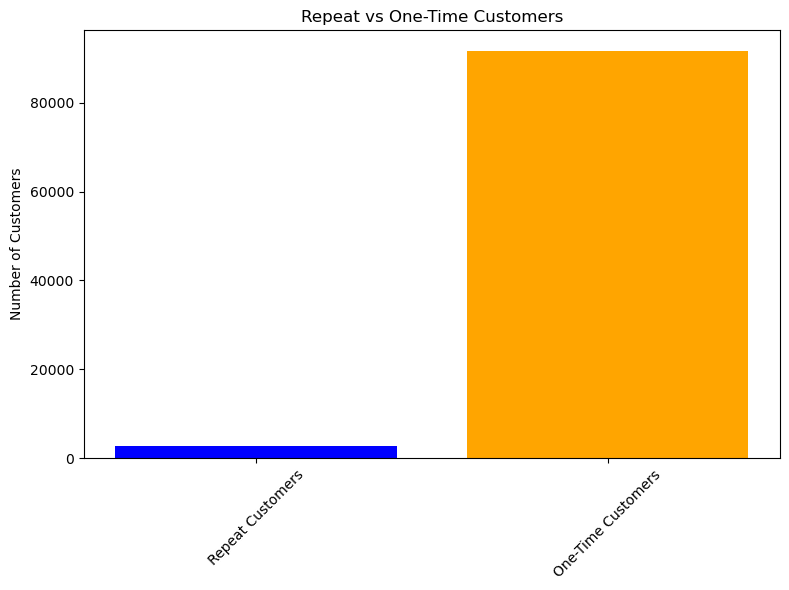

In [14]:
counts = olist["customer_unique_id"].value_counts()
counts_more_than_once = counts[counts > 1]
repeat = counts_more_than_once.shape[0]
total = olist.shape[0]
print(
    f"{repeat} Repeat customers, {olist.shape[0]-repeat} toal customers, {(repeat/total) * 100} percent of customers repeated"
)
# Plotting
plt.figure(figsize=(8, 6))
plt.bar(
    ["Repeat Customers", "One-Time Customers"],
    [repeat, olist.shape[0] - repeat],
    color=["blue", "orange"],
)
plt.ylabel("Number of Customers")
plt.title("Repeat vs One-Time Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


~3% repeat buyers which is insignificant but we shall see what to do with it. For now the plan is to binarize it

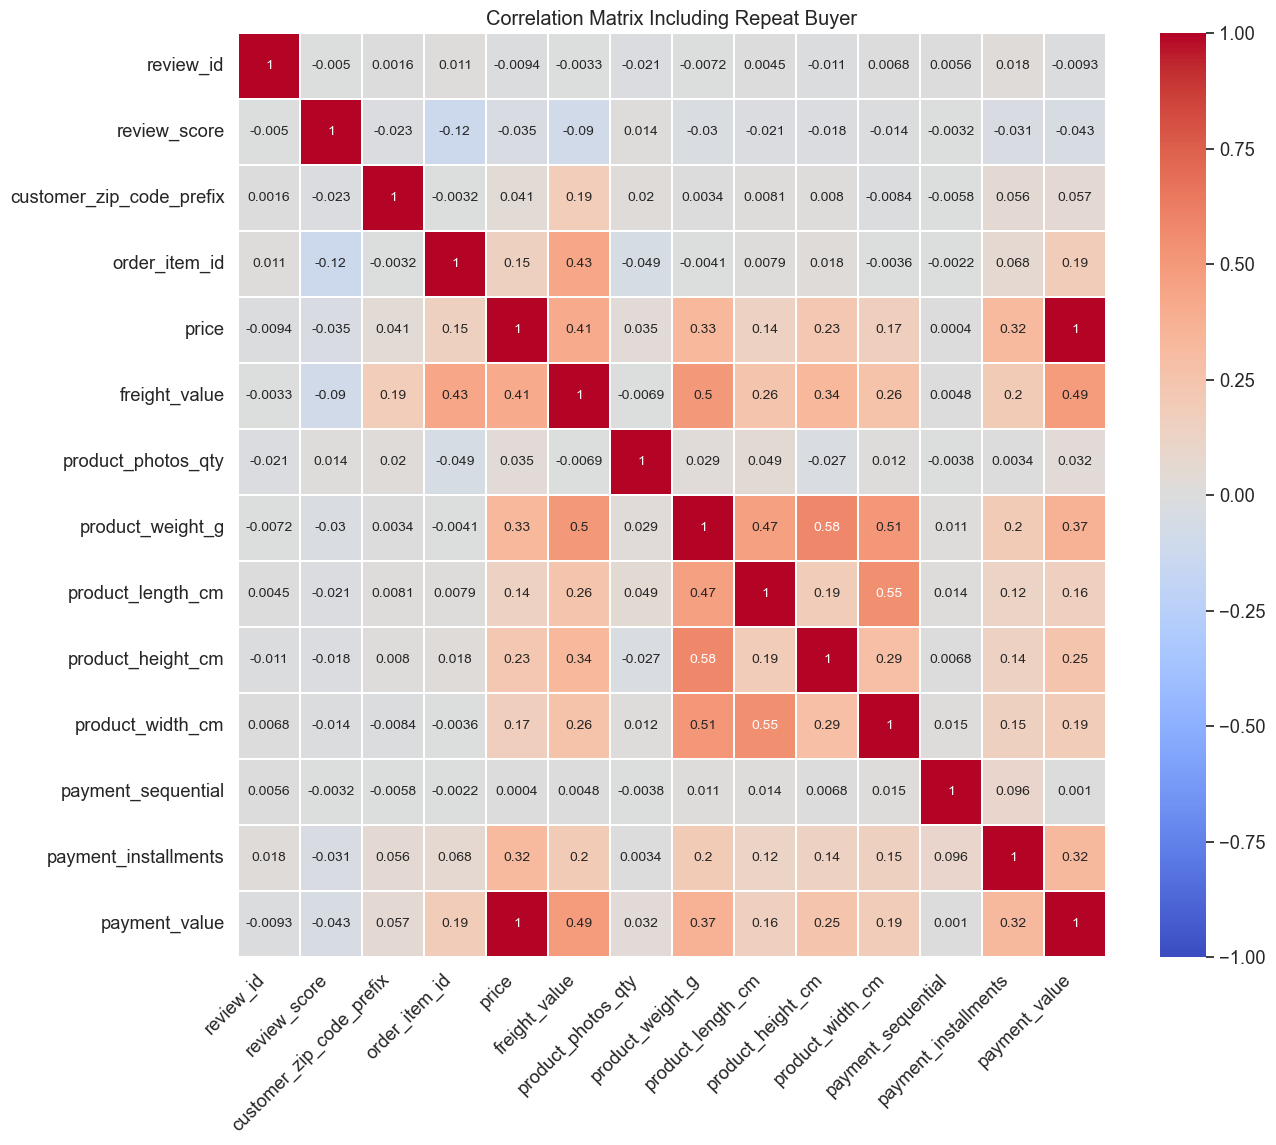

In [15]:
# Calculate the correlation matrix
corr_matrix = olist.corr()

# Plot the correlation matrix with spacing adjustments
plt.figure(figsize=(14, 12))  # Increase figure size
sns.set(font_scale=1.2)  # Increase font scale for better readability
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5,  # Add lines between cells for better separation
    annot_kws={"size": 10},  # Adjust annotation size
)
plt.title("Correlation Matrix Including Repeat Buyer")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better spacing
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.show()


Main Insights:

Price and Payment Value: Strongly correlated (0.49), meaning higher priced items generally have higher payment values.
Product Dimensions: Product length, height, and width are all positively correlated, suggesting larger products tend to be large in multiple dimensions.

Freight Value and Total Price: Moderately correlated (0.49), indicating that higher total prices are associated with higher freight values.
Order Item ID and Product Width: Moderately correlated (0.63), possibly indicating that certain items have consistent product dimensions.
Repeat Buyer: Correlation with other features is weak, implying repeat buying status is not strongly linked to any specific feature in this dataset.

Low Correlations:

Review Score: Has weak correlations with all features, suggesting review scores do not have a strong linear relationship with any other variable in this matrix.
Customer and Seller Zip Code Prefixes: Show low correlation with other features, indicating location data does not strongly correlate with other attributes in this dataset.

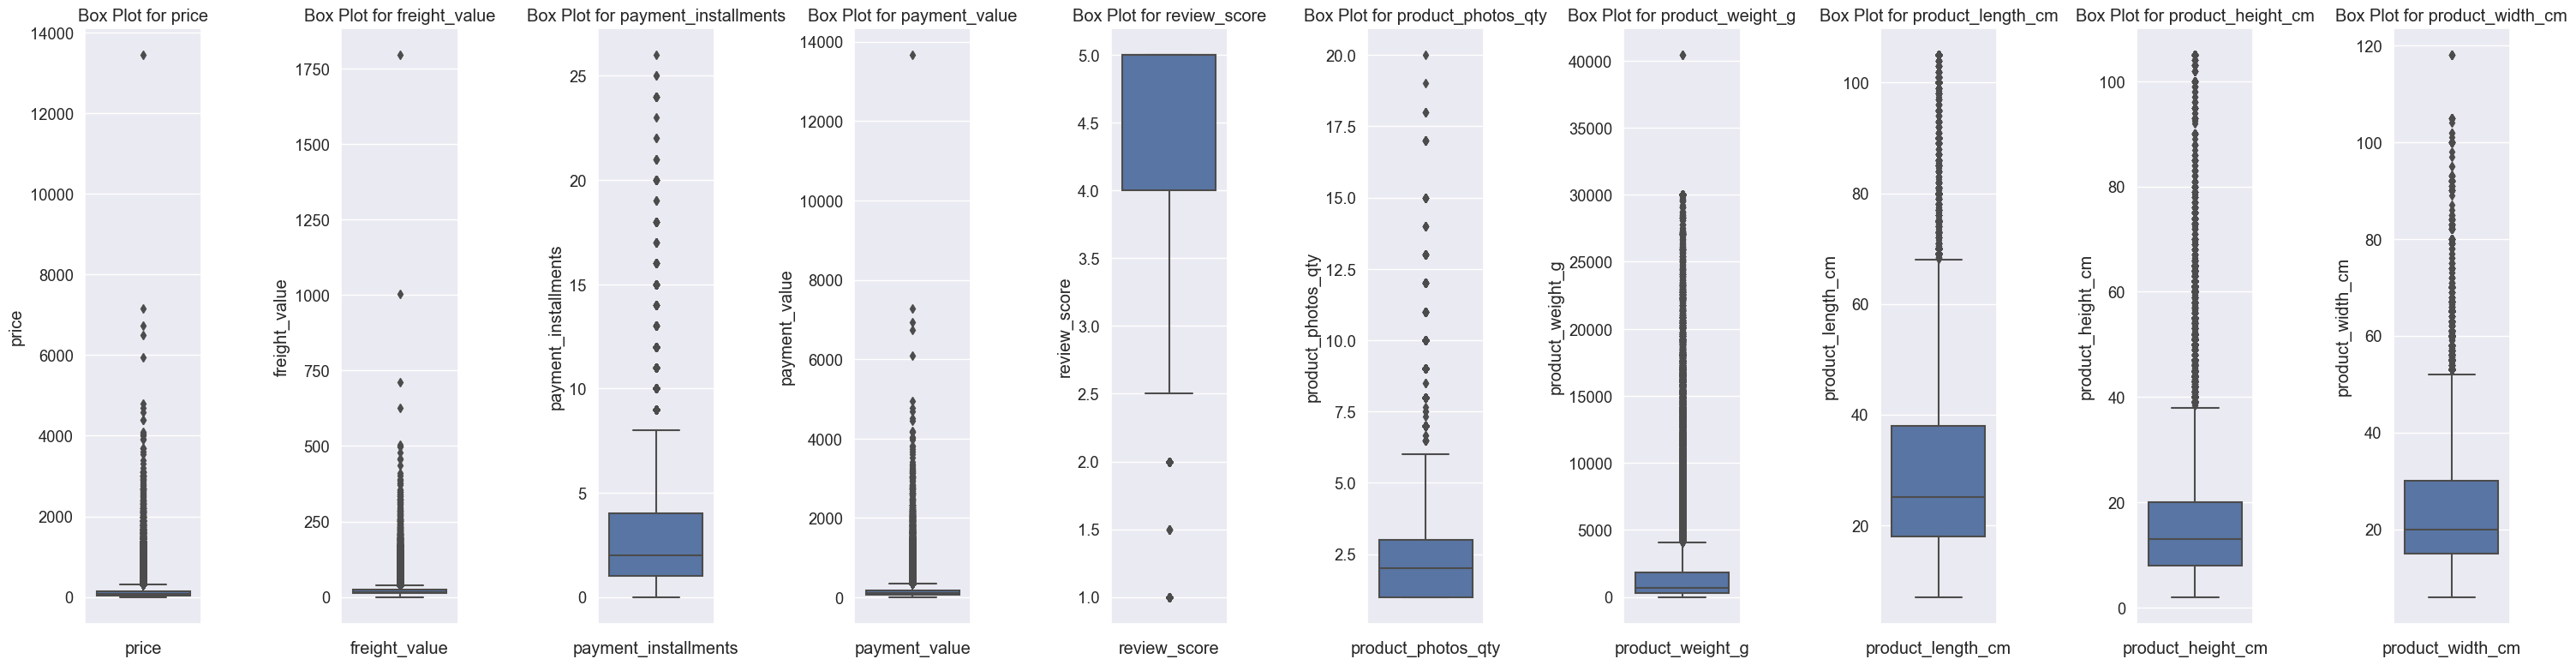

In [16]:
# Select numerical columns for visualization
numerical_columns = [
    "price",
    "freight_value",
    "payment_installments",
    "payment_value",
    "review_score",
    "product_photos_qty",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
]


# Create a single figure for side-by-side box plots
plt.figure(figsize=(30, 8))

# Create subplots for each numerical column
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, len(numerical_columns), i)
    sns.boxplot(y=olist[column])
    plt.title(f"Box Plot for {column}")
    plt.xlabel(column)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


Alot of outliers due to massive data size for the payment values the outliers are good since they indicate that customers may have had a good experience with olist

### General Trend of e-commerce

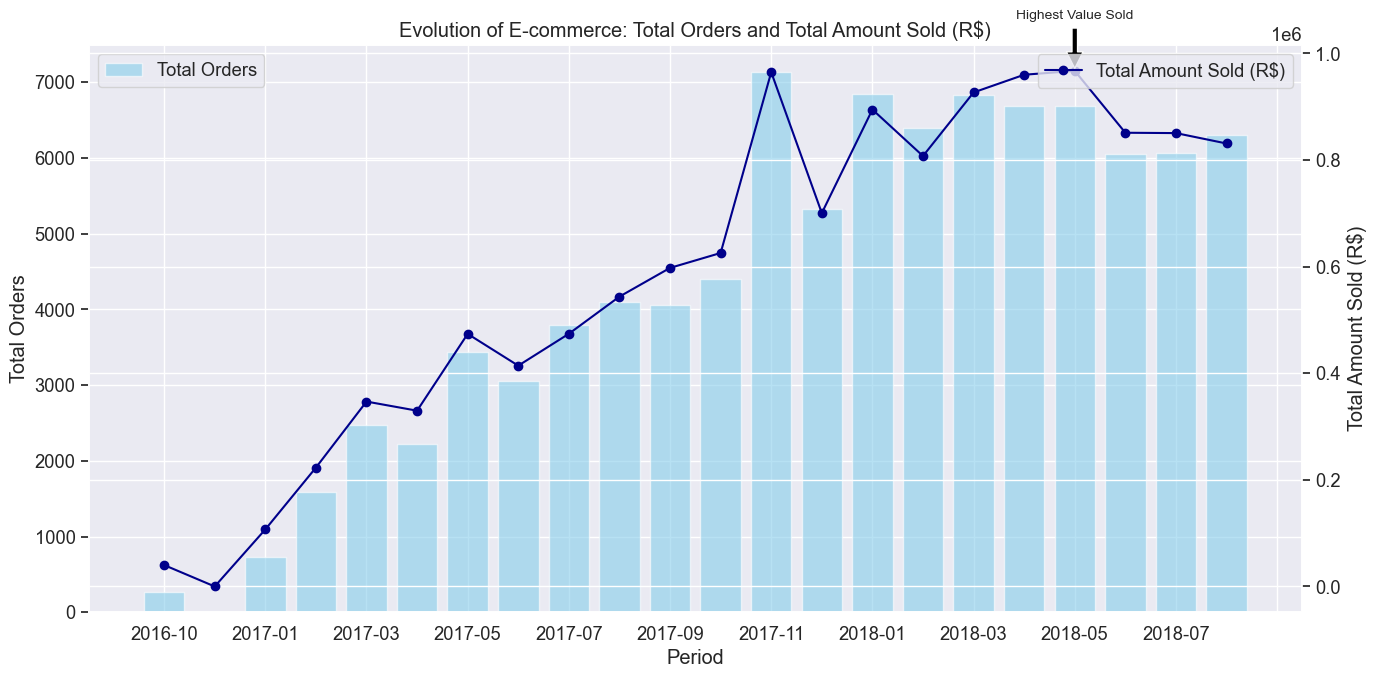

In [17]:
# Convert 'order_purchase_timestamp' to datetime if it's not already
olist["order_purchase_timestamp"] = pd.to_datetime(olist["order_purchase_timestamp"])

# Extract year-month period from the timestamp
olist["period"] = olist["order_purchase_timestamp"].dt.to_period("M")

# Group by period and calculate total orders and total amount sold
monthly_orders = (
    olist.groupby("period")
    .agg({"order_id": "count", "price": "sum"})
    .reset_index()
)

# Convert period to string for plotting
monthly_orders["period"] = monthly_orders["period"].astype(str)

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for total orders
ax1.bar(
    monthly_orders["period"],
    monthly_orders["order_id"],
    color="skyblue",
    alpha=0.6,
    label="Total Orders",
)
ax1.set_xlabel("Period")
ax1.set_ylabel("Total Orders")
ax1.set_title("Evolution of E-commerce: Total Orders and Total Amount Sold (R$)")
ax1.legend(loc="upper left")

# Line plot for total amount sold
ax2 = ax1.twinx()
ax2.plot(
    monthly_orders["period"],
    monthly_orders["price"],
    color="darkblue",
    marker="o",
    linestyle="-",
    label="Total Amount Sold (R$)",
)
ax2.set_ylabel("Total Amount Sold (R$)")
ax2.legend(loc="upper right")

# Highlight the highest value sold on history
max_value = monthly_orders["price"].max()
max_index = monthly_orders["price"].idxmax()
ax2.annotate(
    "Highest Value Sold",
    xy=(monthly_orders["period"][max_index], max_value),
    xytext=(monthly_orders["period"][max_index], max_value * 1.1),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=10,
    ha="center",
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set major ticks format for better spacing
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))  # Adjust this number as needed

plt.tight_layout()
plt.show()


Highest value sold is in 2018-05
Most orders in 2017-11 month
Lowest money and lowest orders in 2016-11

In [18]:
# Create the 'repeat_buyer' column
olist["repeat_buyer"] = olist.duplicated("customer_unique_id", keep=False).astype(int)

# Verify the column creation
if "repeat_buyer" in olist.columns:
    print("The 'repeat_buyer' column was successfully added to the dataset.")
else:
    print("The 'repeat_buyer' column was NOT added to the dataset.")

# Display the first few rows of the dataset to confirm the presence of 'repeat_buyer' column
display(olist.head(3))

# Print the shape of the dataset to confirm the dimensions
print(olist.shape)


The 'repeat_buyer' column was successfully added to the dataset.


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,product_category_name_english,period,repeat_buyer
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,4.0,...,19.0,8.0,13.0,3,"credit_card, voucher",3,38.71,housewares,2017-10,1
1,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,1,1.0,...,38.0,34.0,34.0,1,credit_card,10,356.12,housewares,2017-11,0
2,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-04-24 09:34:13,2017-05-10 09:17:55,2017-05-12,1,1.0,...,34.0,22.0,28.0,1,boleto,1,267.80,housewares,2017-04,0


(94471, 32)


### Most purchased producst by repeat customers

In [19]:
# Count occurrences of each customer
counts = olist["customer_unique_id"].value_counts()

# Filter customers who have purchased more than once
repeat_customers = counts[counts > 1].index.tolist()

# Filter transactions made by repeat customers
repeat_transactions = olist[olist["customer_unique_id"].isin(repeat_customers)]

# Group by product or category to count occurrences
top_products = (
    repeat_transactions["product_category_name_english"].value_counts().head(10)
)

print("Top Products Purchased by Repeat Customers:")
print(top_products)


Top Products Purchased by Repeat Customers:
bed_bath_table              807
sports_leisure              557
furniture_decor             543
health_beauty               469
computers_accessories       386
housewares                  322
watches_gifts               265
fashion_bags_accessories    211
toys                        189
garden_tools                180
Name: product_category_name_english, dtype: int64


It seems that bed bath table is most preferred by the repeat customers and telephony is least preferred in the top 10 most preferred producst by repeat customers

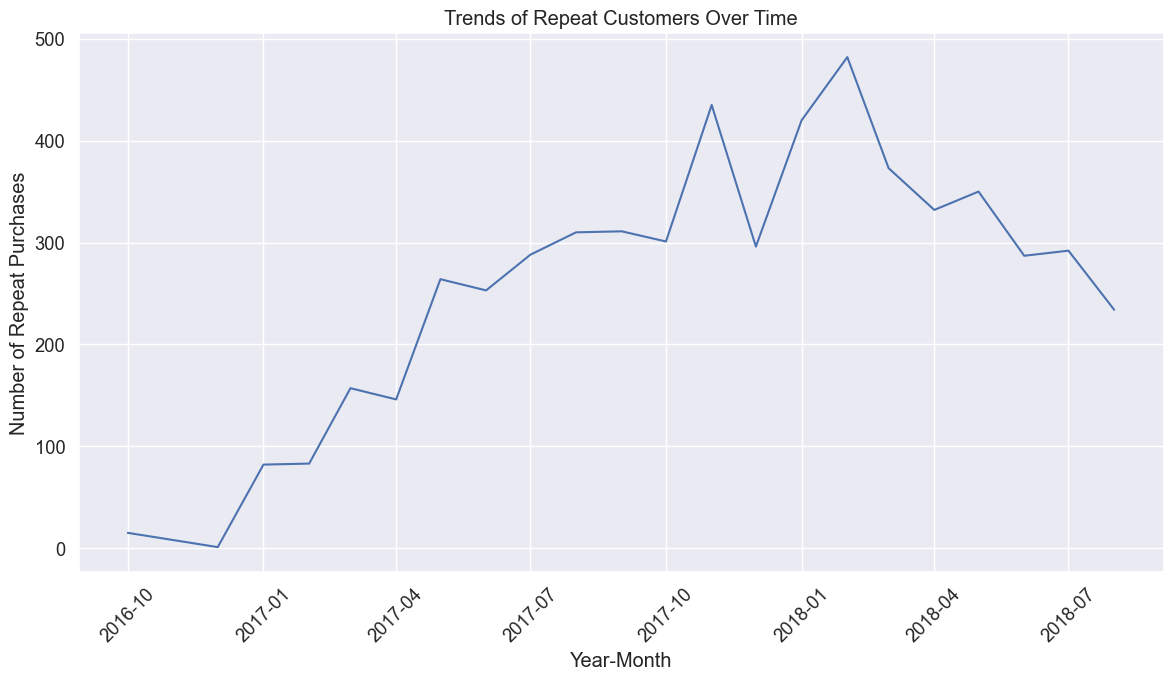

In [20]:
# Identify repeat customers
customer_order_counts = olist.groupby("customer_unique_id")["order_id"].count()
repeat_customers = customer_order_counts[customer_order_counts > 1].index

# Filter orders to include only those from repeat customers
repeat_customer_orders = olist[olist["customer_unique_id"].isin(repeat_customers)]

# Convert order_purchase_timestamp to datetime
repeat_customer_orders["order_purchase_timestamp"] = pd.to_datetime(
    repeat_customer_orders["order_purchase_timestamp"]
)

# Extract year and month from the timestamp
repeat_customer_orders["order_year_month"] = repeat_customer_orders[
    "order_purchase_timestamp"
].dt.to_period("M")

# Group by year and month to count repeat purchases
repeat_purchase_trends = (
    repeat_customer_orders.groupby("order_year_month")
    .size()
    .reset_index(name="repeat_purchases")
)

# Convert order_year_month to datetime for plotting
repeat_purchase_trends["order_year_month"] = repeat_purchase_trends[
    "order_year_month"
].dt.to_timestamp()

# Plotting the trends
plt.figure(figsize=(14, 7))
sns.lineplot(data=repeat_purchase_trends, x="order_year_month", y="repeat_purchases")
plt.title("Trends of Repeat Customers Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Repeat Purchases")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In between 2018-1 and 2018-4 is where there is the most number of repeat orders. Overall, an increasing trend can be seen form 2016 to start of 2018 and then it declines from there. 

### State Analysis
which state has the most repeat buyers

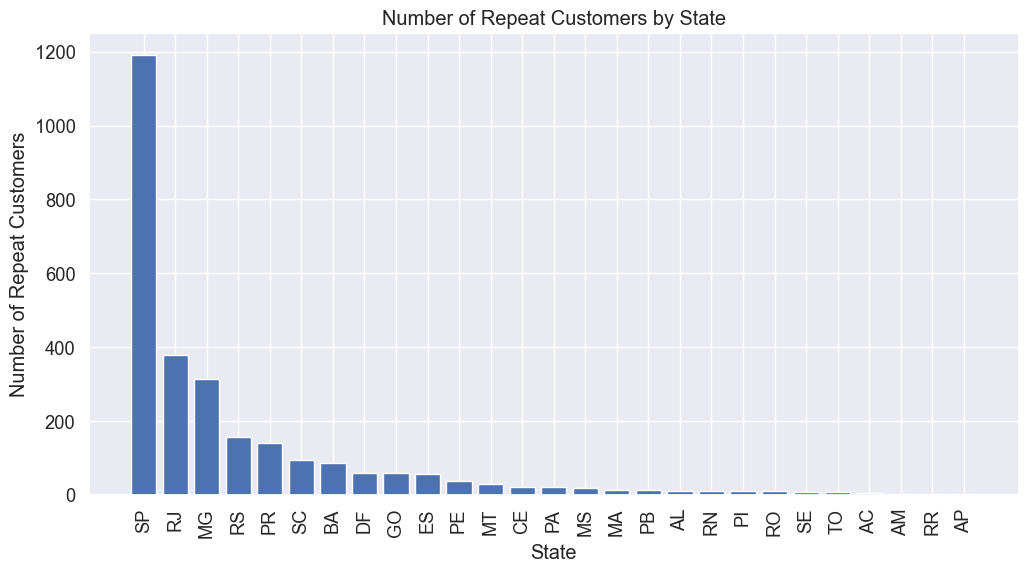

In [21]:
# Identify repeat customers
repeat_customers = olist.groupby("customer_unique_id").filter(lambda x: len(x) > 1)

# Group by state and count the number of unique repeat customers in each state
repeat_customer_location = (
    repeat_customers.groupby("customer_state")["customer_unique_id"]
    .nunique()
    .reset_index()
)
repeat_customer_location.columns = ["state", "repeat_customer_count"]
repeat_customer_location = repeat_customer_location.sort_values(
    by="repeat_customer_count", ascending=False
)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(
    repeat_customer_location["state"], repeat_customer_location["repeat_customer_count"]
)
plt.xlabel("State")
plt.ylabel("Number of Repeat Customers")
plt.title("Number of Repeat Customers by State")
plt.xticks(rotation=90)
plt.show()


Obviously, "SP" (Sao Polo) represents the biggest chunk of repeat customers.

It's worth mentioning that these states also have a lot of repat customers:

MG (Minas Gerais)
RJ (Rio de Janeiro)
Finally, smaller but still accounting for a consequent share of repeat customers:

RS (Rio Grande do Sul)
PR (Paraná)
SC (Santa Catarina)
BA (Bahia)

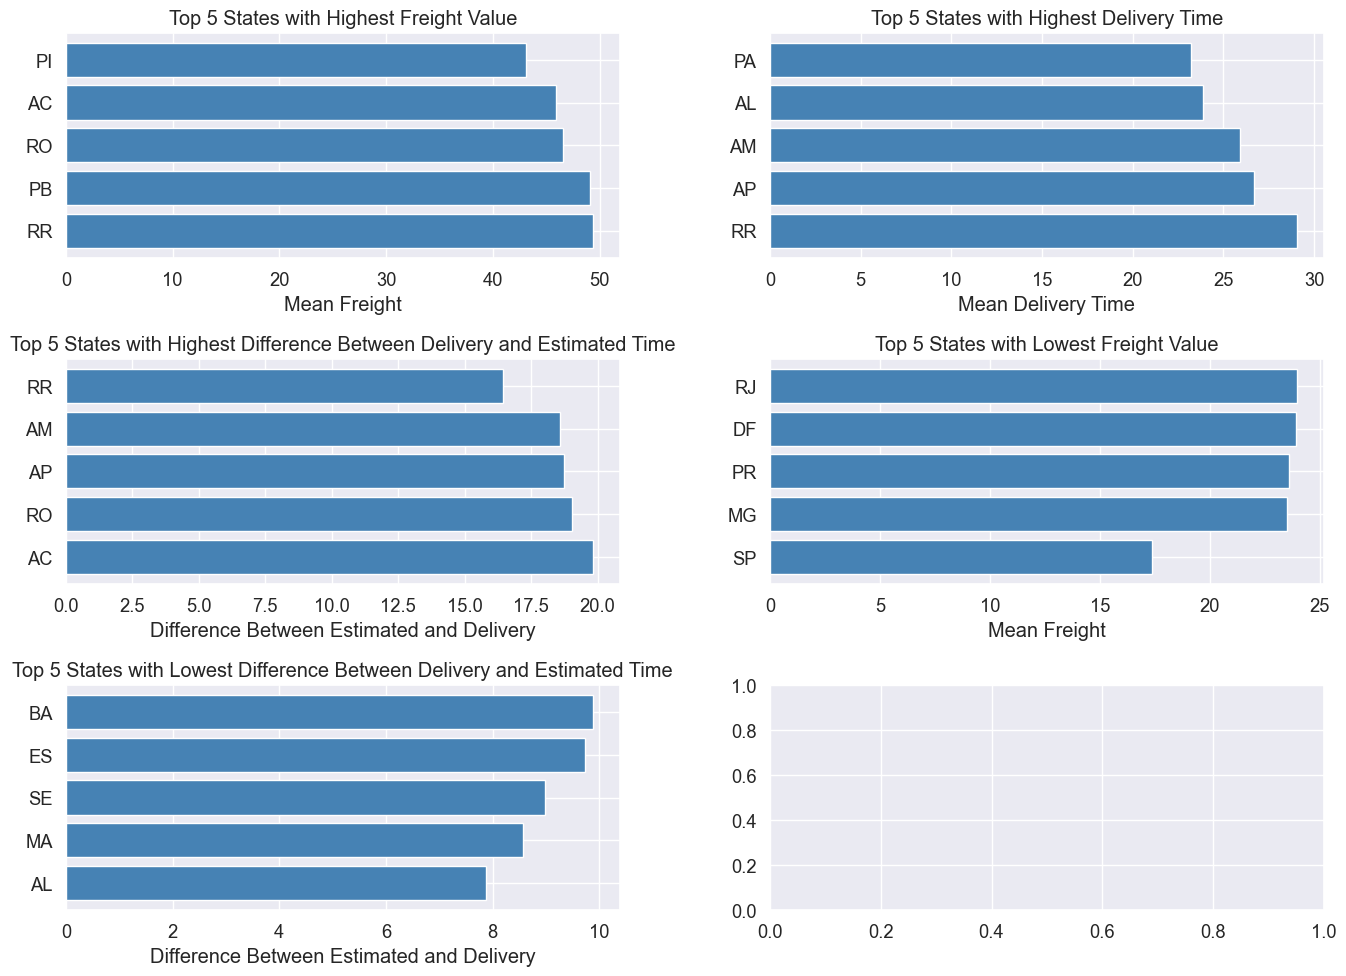

In [22]:
# Calculate delivery time and difference between estimated and actual delivery time
olist["delivery_time"] = (
    olist["order_delivered_customer_date"] - olist["order_purchase_timestamp"]
).dt.days
olist["diff_delivery_estimated"] = (
    olist["order_estimated_delivery_date"] - olist["order_delivered_customer_date"]
).dt.days

# Calculate the metrics
mean_freight = olist["freight_value"].mean()
mean_delivery_time = olist["delivery_time"].mean()
mean_diff_estimated_delivery = olist["diff_delivery_estimated"].mean()

# Top 5 states
top_5_freight = (
    olist.groupby("customer_state")["freight_value"].mean().nlargest(5).reset_index()
)
top_5_delivery_time = (
    olist.groupby("customer_state")["delivery_time"].mean().nlargest(5).reset_index()
)
top_5_diff_delivery_estimated = (
    olist.groupby("customer_state")["diff_delivery_estimated"]
    .mean()
    .nlargest(5)
    .reset_index(name="diff_delivery_estimated")
)

# Bottom 5 states
bottom_5_freight = (
    olist.groupby("customer_state")["freight_value"].mean().nsmallest(5).reset_index()
)
bottom_5_delivery_time = (
    olist.groupby("customer_state")["delivery_time"].mean().nsmallest(5).reset_index()
)
bottom_5_diff_delivery_estimated = (
    olist.groupby("customer_state")["diff_delivery_estimated"]
    .mean()
    .nsmallest(5)
    .reset_index(name="diff_delivery_estimated")
)

# Plotting the graphs
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# Top 5 states with highest freight value
axs[0, 0].barh(
    top_5_freight["customer_state"], top_5_freight["freight_value"], color="steelblue"
)
axs[0, 0].set_title("Top 5 States with Highest Freight Value")
axs[0, 0].set_xlabel("Mean Freight")

# Top 5 states with highest delivery time
axs[0, 1].barh(
    top_5_delivery_time["customer_state"],
    top_5_delivery_time["delivery_time"],
    color="steelblue",
)
axs[0, 1].set_title("Top 5 States with Highest Delivery Time")
axs[0, 1].set_xlabel("Mean Delivery Time")

# Top 5 states with highest difference between delivery and estimated time
axs[1, 0].barh(
    top_5_diff_delivery_estimated["customer_state"],
    top_5_diff_delivery_estimated["diff_delivery_estimated"],
    color="steelblue",
)
axs[1, 0].set_title(
    "Top 5 States with Highest Difference Between Delivery and Estimated Time"
)
axs[1, 0].set_xlabel("Difference Between Estimated and Delivery")

# Bottom 5 states with lowest freight value
axs[1, 1].barh(
    bottom_5_freight["customer_state"],
    bottom_5_freight["freight_value"],
    color="steelblue",
)
axs[1, 1].set_title("Top 5 States with Lowest Freight Value")
axs[1, 1].set_xlabel("Mean Freight")


# Bottom 5 states with lowest difference between delivery and estimated time
axs[2, 0].barh(
    bottom_5_diff_delivery_estimated["customer_state"],
    bottom_5_diff_delivery_estimated["diff_delivery_estimated"],
    color="steelblue",
)
axs[2, 0].set_title(
    "Top 5 States with Lowest Difference Between Delivery and Estimated Time"
)
axs[2, 0].set_xlabel("Difference Between Estimated and Delivery")

plt.tight_layout()
plt.show()


### Top 5 States with Highest Freight Value:

PI (Piauí), AC (Acre), RO (Rondônia), PB (Paraíba), RR (Roraima):
Insight: High freight values may deter repeat buyers in these states. Maybe implementing targeted promotions or subsidizing shipping costs could incentivize repeat purchases.
### Top 5 States with Highest Delivery Time:

PA (Pará), AL (Alagoas), AM (Amazonas), AP (Amapá), RR (Roraima):
Insight: Long delivery times might frustrate customers, reducing the likelihood of repeat purchases. Improving logistics or setting realistic delivery expectations could enhance customer satisfaction and loyalty.

### Top 5 States with Highest Difference Between Delivery and Estimated Time
RR (Roraima), AM (Amazonas), AP (Amapá), RO (Rondônia), AC (Acre):
Insight: Significant discrepancies between estimated and actual delivery times can erode trust and lose potential repeat buyers. Accurate delivery estimates and proactive communication about delays can help maintain customer trust and encourage repeat buying.

### Top 5 States with Lowest Freight Value:
RJ (Rio de Janeiro), DF (Distrito Federal), PR (Paraná), MG (Minas Gerais), SP (São Paulo):
Insight: Lower freight costs are attractive to customers and can encourage repeat purchases. Highlighting affordable shipping options in marketing campaigns may drive repeat business in these states.

### Top 5 States with Lowest Difference Between Delivery and Estimated Time
BA (Bahia), ES (Espírito Santo), SE (Sergipe), MA (Maranhão), AL (Alagoas):
Insight: Accurate delivery estimates build trust and enhance customer experience. Focusing on maintaining or improving this reliability can help in retaining customers and encouraging repeat purchases.


### Payments

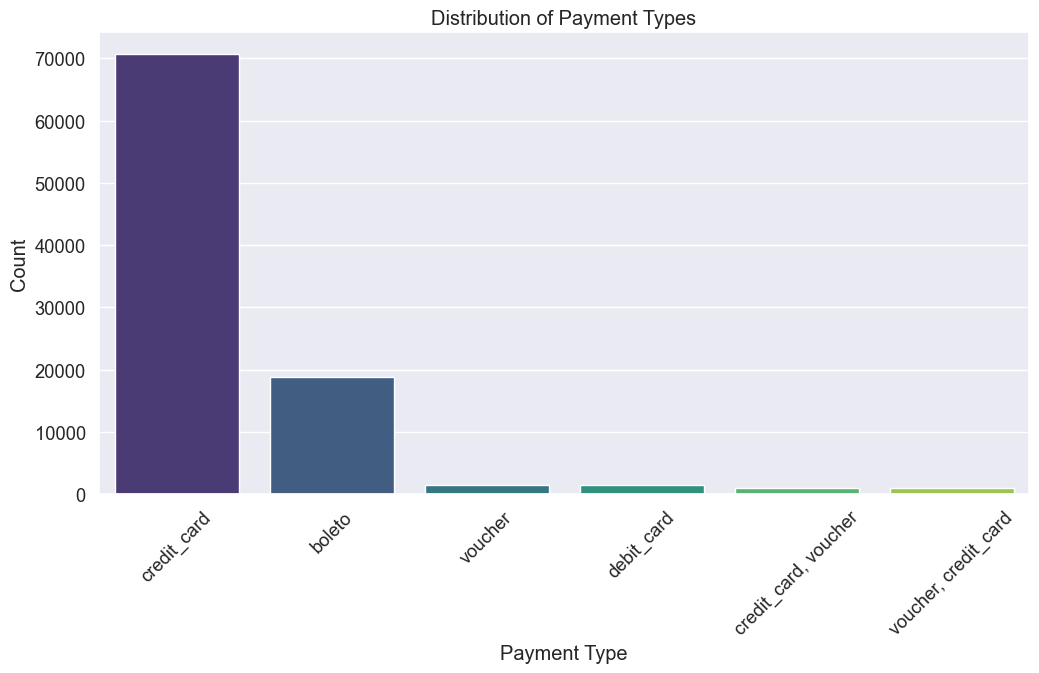

In [23]:
# Count the frequency of each payment type
payment_type_counts = olist["payment_type"].value_counts().reset_index()
payment_type_counts.columns = ["payment_type", "count"]

# Plot the distribution of payment types
plt.figure(figsize=(12, 6))
sns.barplot(x="payment_type", y="count", data=payment_type_counts, palette="viridis")
plt.xlabel("Payment Type")
plt.ylabel("Count")
plt.title("Distribution of Payment Types")
plt.xticks(rotation=45)
plt.show()


In [24]:
# Calculate the percentage of repeat buyers by payment type
repeat_buyer_counts = (
    olist.groupby("payment_type")["repeat_buyer"]
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    * 100
)

# Reset the index to convert the grouped indices to columns
repeat_buyer_counts = repeat_buyer_counts.reset_index()

# Rename the columns for better readability
repeat_buyer_counts.columns = ["Payment Type", "non-repeat", "repeat"]

# Print the calculated percentages for verification
print(repeat_buyer_counts)


           Payment Type  non-repeat    repeat
0                boleto   94.194338  5.805662
1           credit_card   93.987570  6.012430
2  credit_card, voucher   92.737430  7.262570
3            debit_card   94.682320  5.317680
4               voucher   90.095628  9.904372
5  voucher, credit_card   92.992424  7.007576


Across the board we can see that credit card is the most frequent payment option followed by boleto. However the repeat buyers shows that they prefer boleto over credit card payments. Its surprising that credit card is the lowest amongst the payment types for repeat customers

### Review score

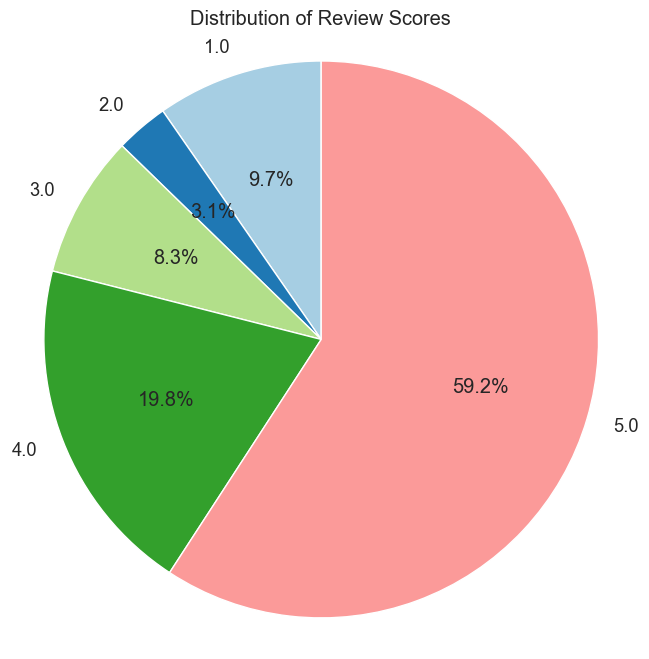

In [25]:
# Extract the review scores
review_scores = olist['review_score'].round()

# Calculate the distribution of review scores
review_distribution = review_scores.value_counts().sort_index()

# Plot the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    review_distribution,
    labels=review_distribution.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired(range(len(review_distribution)))
)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add title
plt.title('Distribution of Review Scores')

# Show the plot
plt.show()

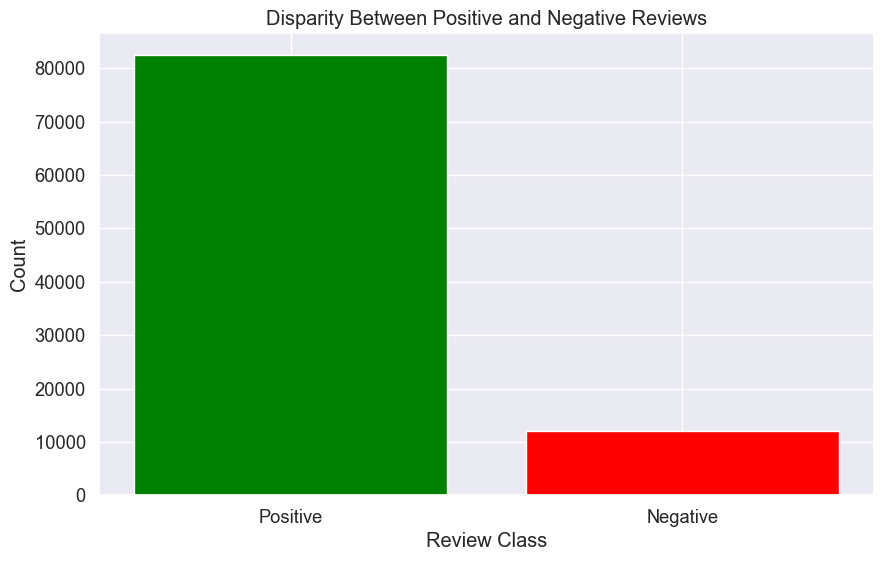

In [26]:
# Classify reviews as positive or negative
olist["review_class"] = olist["review_score"].apply(
    lambda x: "Positive" if x >= 2.5 else "Negative"
)

# Count the frequency of positive and negative reviews
review_class_counts = olist["review_class"].value_counts().reset_index()
review_class_counts.columns = ["review_class", "count"]

# Plot the disparity between positive and negative reviews
plt.figure(figsize=(10, 6))
plt.bar(
    review_class_counts["review_class"],
    review_class_counts["count"],
    color=["green", "red"],
)
plt.xlabel("Review Class")
plt.ylabel("Count")
plt.title("Disparity Between Positive and Negative Reviews")
plt.show()

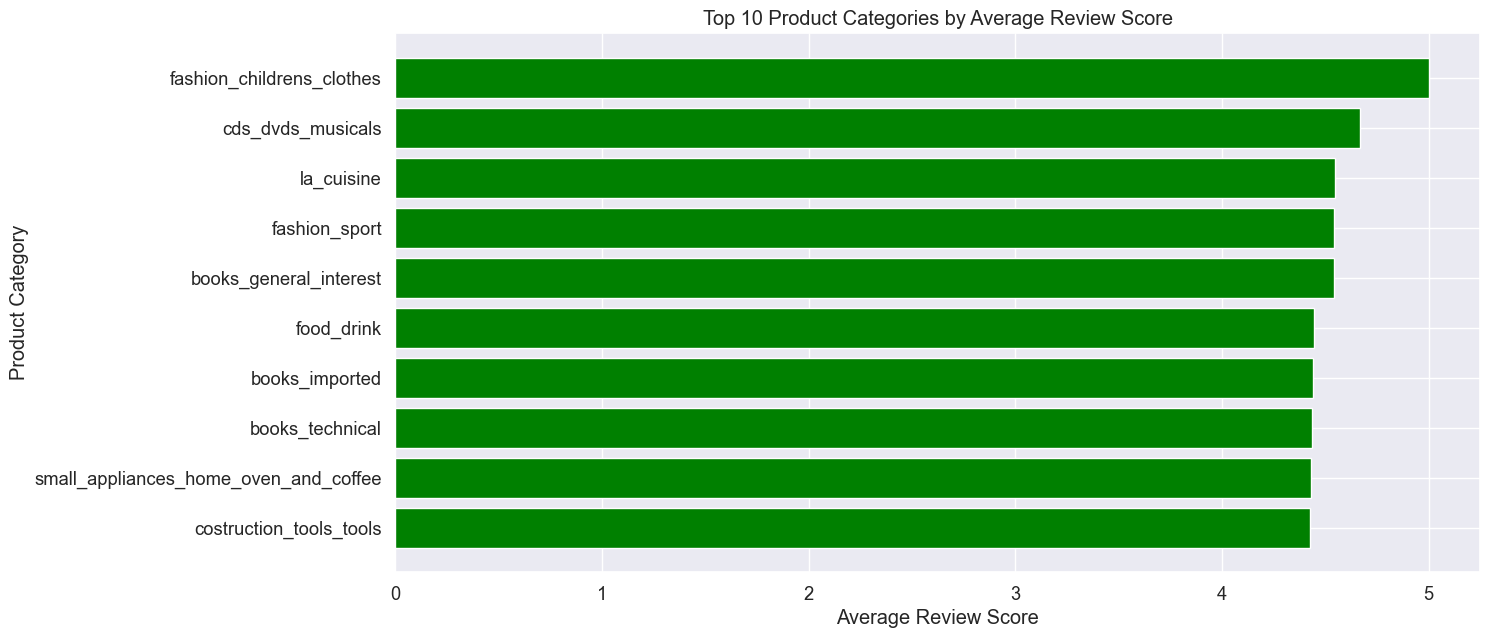

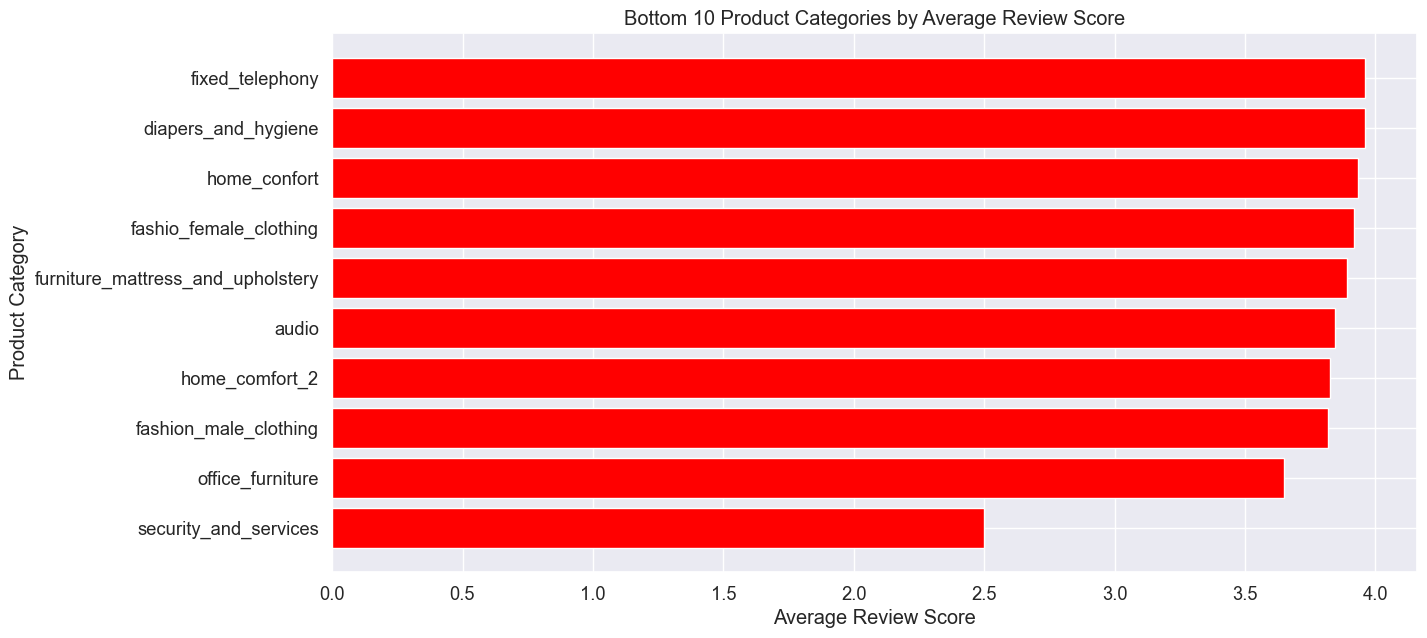

In [27]:
# Group by product category and calculate the mean review score
category_review_scores = (
    olist.groupby("product_category_name_english")["review_score"].mean().reset_index()
)

# Sort the categories by mean review score
category_review_scores = category_review_scores.sort_values(
    by="review_score", ascending=False
)

# Display the top and bottom categories
top_categories = category_review_scores.head(10)
bottom_categories = category_review_scores.tail(10)

# Plot top 10 product categories by review score
plt.figure(figsize=(14, 7))
plt.barh(
    top_categories["product_category_name_english"],
    top_categories["review_score"],
    color="green",
)
plt.xlabel("Average Review Score")
plt.ylabel("Product Category")
plt.title("Top 10 Product Categories by Average Review Score")
plt.gca().invert_yaxis()
plt.show()

# Plot bottom 10 product categories by review score
plt.figure(figsize=(14, 7))
plt.barh(
    bottom_categories["product_category_name_english"],
    bottom_categories["review_score"],
    color="red",
)
plt.xlabel("Average Review Score")
plt.ylabel("Product Category")
plt.title("Bottom 10 Product Categories by Average Review Score")
plt.gca().invert_yaxis()
plt.show()


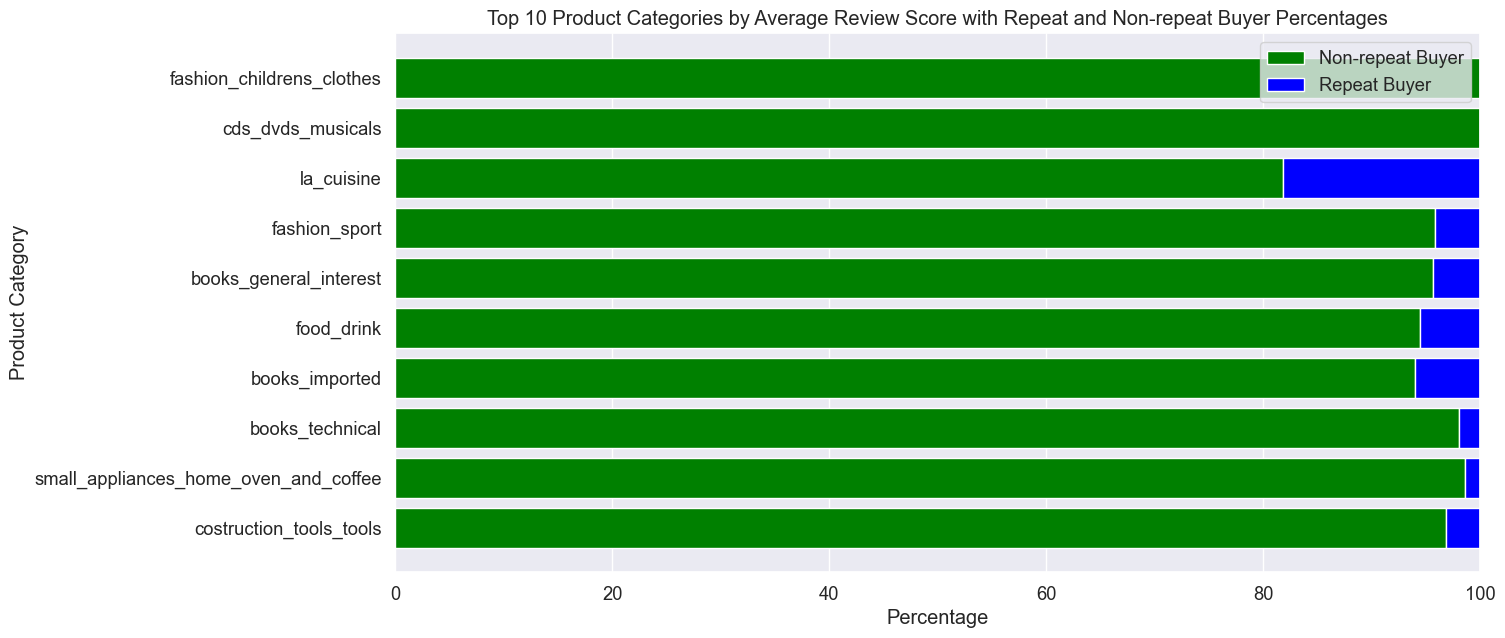

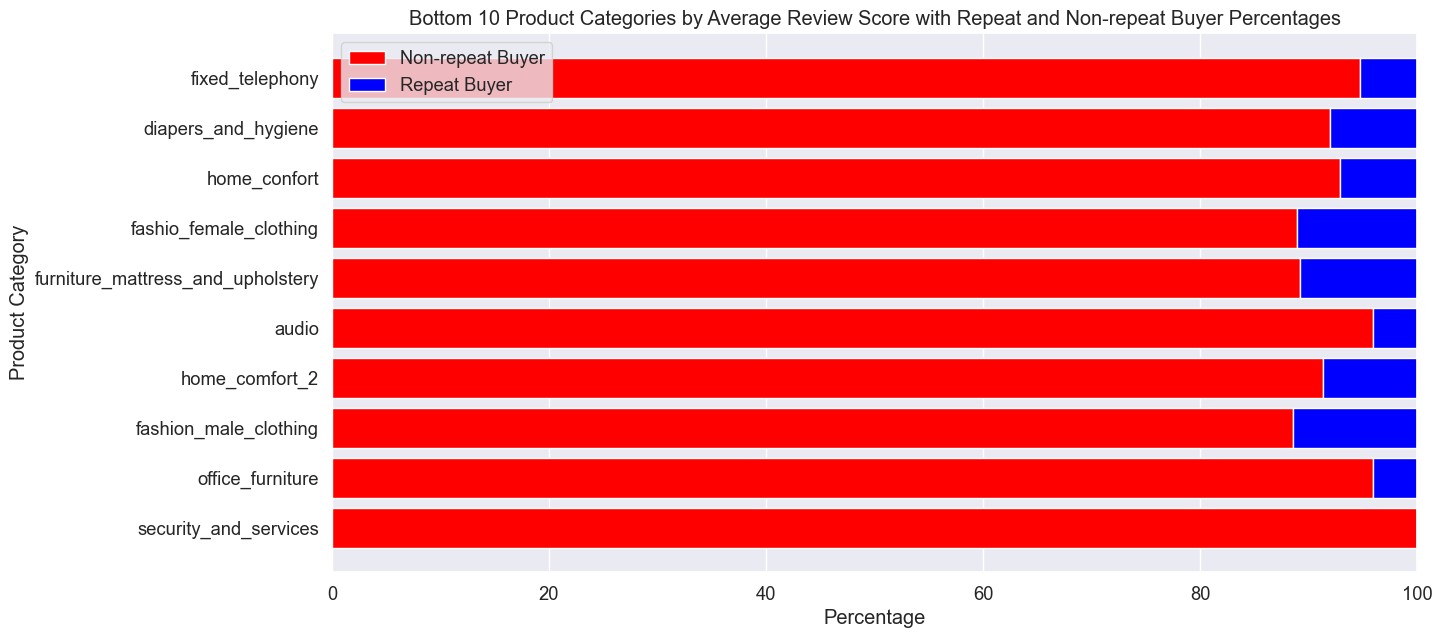

In [28]:
# Calculate the percentage of repeat and non-repeat buyers for each product category
category_buyer_counts = (
    olist.groupby("product_category_name_english")["repeat_buyer"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
)

category_buyer_counts.columns = ["product_category_name_english", "non_repeat_buyer", "repeat_buyer"]
category_buyer_counts["repeat_buyer"] *= 100  # Convert to percentage
category_buyer_counts["non_repeat_buyer"] *= 100  # Convert to percentage

# Sort the categories by mean review score
category_review_scores = (
    olist.groupby("product_category_name_english")["review_score"].mean().reset_index()
)
category_review_scores = category_review_scores.sort_values(by="review_score", ascending=False)

# Merge with the buyer counts to get a single dataframe
category_stats = pd.merge(category_review_scores, category_buyer_counts, on="product_category_name_english")

# Select top 10 categories by review score
top_categories = category_stats.head(10)

# Plot top 10 product categories by review score with repeat and non-repeat buyer percentages
plt.figure(figsize=(14, 7))
plt.barh(
    top_categories["product_category_name_english"],
    top_categories["non_repeat_buyer"],
    color="green",
    label="Non-repeat Buyer"
)
plt.barh(
    top_categories["product_category_name_english"],
    top_categories["repeat_buyer"],
    left=top_categories["non_repeat_buyer"],
    color="blue",
    label="Repeat Buyer"
)

plt.xlabel("Percentage")
plt.ylabel("Product Category")
plt.title("Top 10 Product Categories by Average Review Score with Repeat and Non-repeat Buyer Percentages")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Select bottom 10 categories by review score
bottom_categories = category_stats.tail(10)

# Plot bottom 10 product categories by review score with repeat and non-repeat buyer percentages
plt.figure(figsize=(14, 7))
plt.barh(
    bottom_categories["product_category_name_english"],
    bottom_categories["non_repeat_buyer"],
    color="red",
    label="Non-repeat Buyer"
)
plt.barh(
    bottom_categories["product_category_name_english"],
    bottom_categories["repeat_buyer"],
    left=bottom_categories["non_repeat_buyer"],
    color="blue",
    label="Repeat Buyer"
)

plt.xlabel("Percentage")
plt.ylabel("Product Category")
plt.title("Bottom 10 Product Categories by Average Review Score with Repeat and Non-repeat Buyer Percentages")
plt.legend()
plt.gca().invert_yaxis()
plt.show()


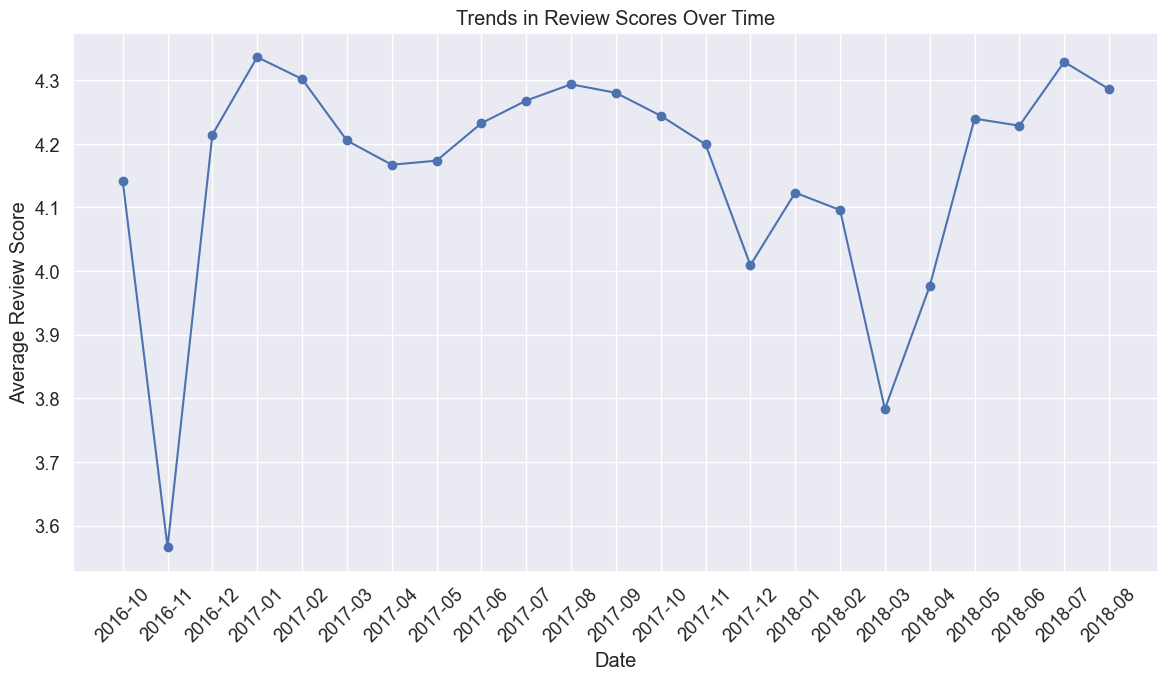

In [29]:
# Convert review_creation_date to datetime
olist["review_creation_date"] = pd.to_datetime(olist["review_creation_date"])

# Group by review creation month and calculate the mean review score
olist["review_year_month"] = olist["review_creation_date"].dt.to_period("M")
monthly_review_scores = (
    olist.groupby("review_year_month")["review_score"].mean().reset_index()
)

# Plot the review score trends over time
plt.figure(figsize=(14, 7))
plt.plot(
    monthly_review_scores["review_year_month"].astype(str),
    monthly_review_scores["review_score"],
    marker="o",
)
plt.xlabel("Date")
plt.ylabel("Average Review Score")
plt.title("Trends in Review Scores Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


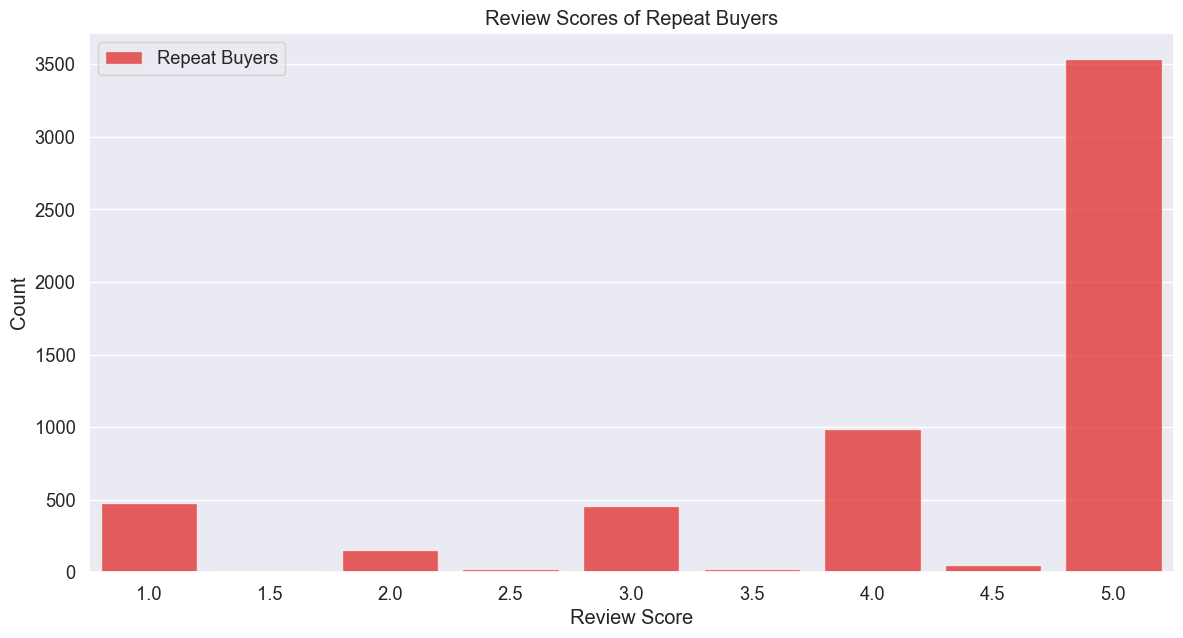

In [30]:
repeat_buyers = olist[olist["repeat_buyer"] == 1]

# Create a count plot for review scores
plt.figure(figsize=(14, 7))

# Plot for repeat buyers
sns.countplot(
    x="review_score", data=repeat_buyers, color="red", alpha=0.7, label="Repeat Buyers"
)

# Add labels and title
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.title("Review Scores of Repeat Buyers")
plt.legend()

# Show the plot
plt.show()


#### Insights
There is a large chunk of positive review scores and 5/5 scores across the graphs. Even most repeat buyers rate their products a full 5/5. A thing to note is that more people rate their products 1/5 than 2 or 3 meaning some products are either aboslutely bad or maybe because of delivery times they get rated badly. Trends in review score also support the high number of 1/5 ratings.
Repeat buyers also rate their purchases 5/5 most of the time

### Delivery times

In [31]:
olist["delivery_duration"] = (
    pd.to_datetime(olist["order_delivered_customer_date"])
    - pd.to_datetime(olist["order_approved_at"])
).dt.days


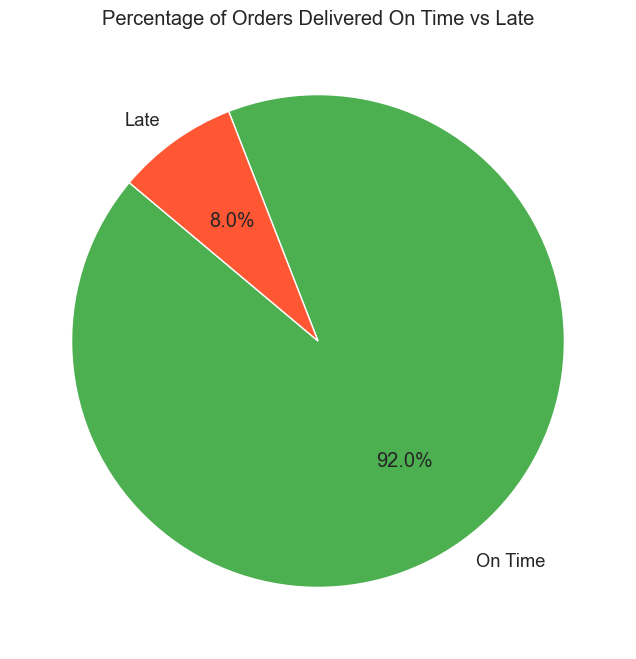

In [32]:
# Create a column for on-time delivery
olist["on_time"] = (
    olist["order_delivered_customer_date"] <= olist["order_estimated_delivery_date"]
)

# Count the number of on-time and late deliveries
on_time_counts = olist["on_time"].value_counts()

# Define labels for the pie chart
labels = ["On Time", "Late"]

# Map boolean values to labels
on_time_counts.index = on_time_counts.index.map({True: "On Time", False: "Late"})

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    on_time_counts,
    labels=on_time_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=["#4CAF50", "#FF5733"],
)
plt.title("Percentage of Orders Delivered On Time vs Late")
plt.show()


In [33]:
# Separate DataFrames for on-time and late deliveries
on_time_df = olist[olist["on_time"] == True]
late_df = olist[olist["on_time"] == False]

# Aggregate product counts for on-time deliveries
on_time_customers = (
    on_time_df.groupby("customer_unique_id")["order_id"].count().reset_index()
)
on_time_customers.columns = ["customer_unique_id", "order_count"]

# Aggregate product counts for late deliveries
late_customers = late_df.groupby("customer_unique_id")["order_id"].count().reset_index()
late_customers.columns = ["customer_unique_id", "order_count"]

# Sort and get top 5 customers for on-time deliveries
top_on_time_customers = on_time_customers.sort_values(
    by="order_count", ascending=False
).head(5)

# Sort and get top 5 customers for late deliveries
top_late_customers = late_customers.sort_values(by="order_count", ascending=False).head(
    5
)

# Display the results
print("Top Customers with On-Time Deliveries:")
print(top_on_time_customers)

print("\nTop Customers with Late Deliveries:")
print(top_late_customers)


Top Customers with On-Time Deliveries:
                     customer_unique_id  order_count
46407  8d50f5eadf50201ccdcedfb9e2ac8455           14
20559  3e43e6105506432c953e165fb2acf44c            8
9105   1b6c7548a2a1f9037c1fd3ddfed95f33            7
33152  6469f99c1f9dfae7733b25662e7f1782            7
6304   12f5d6e1cbf93dafd9dcc19095df0b3d            6

Top Customers with Late Deliveries:
                    customer_unique_id  order_count
5459  ba87a137c5191264841e0be40e53f4ed            3
6163  d26c616e241736e0c1c1ab14150239e7            3
2974  6594a65023bcb47539aa91b0f8e98e00            2
5166  af842a6ed9f77511c9bf46922a29ecb5            2
4841  a48616b0798c3f1d5cae097c18180be8            2


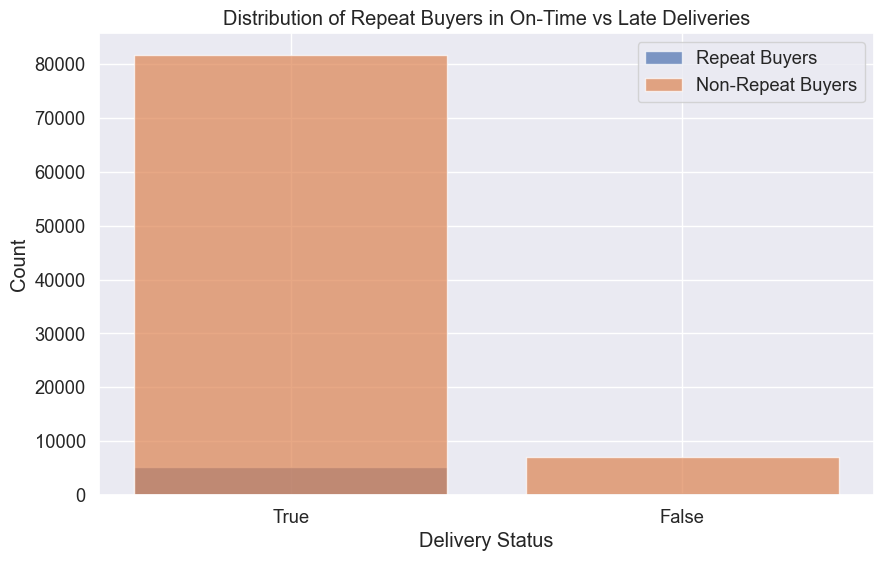

In [34]:
# Count the number of repeat buyers in each on-time and late delivery category
repeat_buyer_on_time_counts = olist[olist["repeat_buyer"] == 1][
    "on_time"
].value_counts()
non_repeat_buyer_on_time_counts = olist[olist["repeat_buyer"] == 0][
    "on_time"
].value_counts()

# Define labels for the bar chart
labels = ["On Time", "Late"]

# Create a DataFrame for easy plotting
repeat_buyer_df = repeat_buyer_on_time_counts.reset_index()
repeat_buyer_df.columns = ["on_time", "count"]
repeat_buyer_df["category"] = "Repeat Buyers"

non_repeat_buyer_df = non_repeat_buyer_on_time_counts.reset_index()
non_repeat_buyer_df.columns = ["on_time", "count"]
non_repeat_buyer_df["category"] = "Non-Repeat Buyers"

combined_df = pd.concat([repeat_buyer_df, non_repeat_buyer_df])

# Plot the bar chart
plt.figure(figsize=(10, 6))
for category in combined_df["category"].unique():
    subset = combined_df[combined_df["category"] == category]
    plt.bar(subset["on_time"].astype(str), subset["count"], label=category, alpha=0.7)

plt.xlabel("Delivery Status")
plt.ylabel("Count")
plt.title("Distribution of Repeat Buyers in On-Time vs Late Deliveries")
plt.legend()
plt.show()


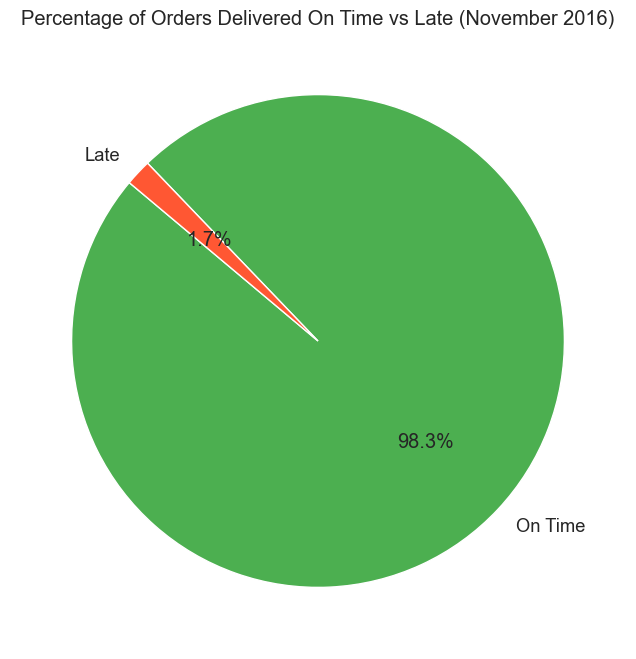

In [35]:
# Filter data for November 2016
november_2016_df = olist[
    (olist['order_delivered_customer_date'] >= '2016-11-01') &
    (olist['order_delivered_customer_date'] <= '2016-11-30')
]

# Create a column for on-time delivery
november_2016_df['on_time'] = november_2016_df['order_delivered_customer_date'] <= november_2016_df['order_estimated_delivery_date']

# Count the number of on-time and late deliveries
on_time_counts_nov_2016 = november_2016_df['on_time'].value_counts()

# Define labels for the pie chart
labels = ['On Time', 'Late']

# Map boolean values to labels
on_time_counts_nov_2016.index = on_time_counts_nov_2016.index.map({True: 'On Time', False: 'Late'})

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(on_time_counts_nov_2016, labels=on_time_counts_nov_2016.index, autopct='%1.1f%%', startangle=140, colors=['#4CAF50', '#FF5733'])
plt.title('Percentage of Orders Delivered On Time vs Late (November 2016)')
plt.show()

In the previous part , we saw that review scores were low for 2016-11 so we thought to see if delivery times were the problem. This graph shows otherwise and maybe the lack of rating is due to abysmal product conditions.

#### Insights

There is a overwhelming difference in on time and late deliveries, we could assume that there will be potentially more repeat customers in the future since from a shoppers POV delivery plays a big part in the e-commerce experience. We can also see the customer with the most on time deliveries is 8d50f, indicating that he should be a repeat buyer and 3e43e could not buy from olist anymore due to the number of late deliveries. The ditribution of repeat byers is obvious since most of them would want to buy products again if they are on time or earlier

## Conclusion



#### Feature Engineering
- New column delivery duration made to calculate days
- on time column made to see if deliveries were infact on time or not
- Binarized repeat buyers
- converted date columns to date format for better analysis
- no need to do sentiment analysis on review message since its captured by review score

#### Key takeaways
- Review score dosent affect repeat buyer but delivery time and payment does have a minimal impact
- Delivery time has an effect since its shown that repeat buyers happen when delivery is on time or faster.
- General trend is that money spent is always more than total order for the month.

#### Feature selection
- Plan is to use on_time, delivery time and payment_value as some features for now including high correlated features like payment_value, product weight ,height, width and length. might consider RFM analysis in the ml pipeline.

After careful consideration here is why binarization is better than RFM.

1. Simplicity and Interpretability:

Binarization: A binary classification problem is simpler and more straightforward. It allows the model to focus on a single target outcome (repeat buyer: yes/no), making the model easier to interpret and understand.
RFM: Using RFM involves multiple dimensions (recency, frequency, and monetary value), which can complicate the model and its interpretation. Each dimension needs to be considered and weighted appropriately.

2. Model Complexity:

Binarization: With a binary target variable, the model can directly learn the patterns associated with repeat buyers. This can be particularly advantageous when using simpler models like logistic regression, which are designed for binary outcomes.
RFM: Incorporating RFM features can increase model complexity, as the model needs to learn the interactions between multiple continuous variables. This may require more sophisticated algorithms and tuning.

3. Performance in Imbalanced Datasets:

Binarization: Techniques for handling class imbalance (e.g., oversampling, undersampling, class weights) are well-established for binary classification problems. These techniques can help improve model performance when repeat buyers are a small fraction of the dataset.
RFM: The effectiveness of RFM features in imbalanced datasets depends on how well the model can learn the relationships between the features and the target variable. This can be more challenging and less direct.